# LAB ASSIGNMENT 8 OF IMAGE SIGNAL PROCESSING

### MANSI KAKKAR

### EE21S063


### IMPORTING LIBRARIES

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

## Reading imageFile.mat 

In [2]:
#initial paramters
n = 8
rho = 0.91
#reading
mat = scipy.io.loadmat('imageFile.mat')['g']
mat

array([[207, 244, 107, 173,  70, 111, 180, 244],
       [230, 246, 233, 193,  11,  97, 192,  86],
       [ 32,  40, 202, 189,  24, 195,  70, 149],
       [232, 247, 244, 100, 209, 202, 173,  57],
       [161, 244, 167, 167, 177,  47, 167, 191],
       [ 24, 123,   9,  43,  80, 124,  41,  65],
       [ 71, 204, 216, 180, 242, 113,  30, 129],
       [139,  36, 238,   8,   8, 164, 127, 178]], dtype=uint8)

## MARKOV - 1 PROCESS

Processing with covariance Matrix $8 X 8$ and $\rho = 0.91$

Compute the Energy Packing Efficiency and De-correlation Efficiency of the Walsh-Haddamard Transform and Discrete Cosine Transform for the above process.

In [3]:
def r_markov(N, rho):
    x = np.arange(N)
    y = np.arange(N)
    _x,_y = np.meshgrid(x,y)
    return rho**np.abs(_x-_y)

## Tridiagonal Matrix

Generating covariance matrix for Markov - 1 process with a given paramter $\rho$

$$Q_{\alpha} = \begin{bmatrix} 1-\alpha & -\alpha & 0 & 0 \\ -\alpha & 1 & -\alpha & 0 \\ 0 & -\alpha & 1 & -\alpha \\ 0 & 0 & -\alpha & 1-\alpha \end{bmatrix}$$


In [4]:
def tridiagonal_structure(alpha, n):
    Q = np.zeros((n,n)) 
    _x,_y = np.meshgrid(np.arange(n),np.arange(n))
    diff = np.abs(_x-_y)
    Q[diff == 0] = 1
    Q[diff == 1] = -alpha
    Q[0,0] = 1-alpha
    Q[n-1,n-1] = 1-alpha
    return Q

## DCT Matrix

Discrete Correlation Transform eqaution is as follows for 1D DCT,

$$
C(k, n) = 2cos\left[\frac{\pi(2n+1)k}{2N}\right], \quad 0 \leq k \leq N-1, \quad 0 \leq n \leq N-1
$$

For normalising the Matrix ,

$$
\frac{1}{\sqrt{4N}}, \quad k = 0
$$

$$
\frac{1}{\sqrt{2N}}, \quad k \geq 1
$$


In [5]:
def DCT_matrix(N):
    _n, _k = np.meshgrid(np.arange(N),np.arange(N))
    alpha = np.sqrt(2/N)
    C = alpha*(np.cos(np.pi*(2*_n+1)*_k/(2*N)))
    C[alpha == 0] = np.sqrt(1/N)
    return C

## Haddamard Matrix

Haddamard Transform Matrices $H_n$, are of $N X N$ form where $N = 2^n$. All the matrices can be generated from $H_1$ matrix,

$$H_1 = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$

$$
H_{n} = H_{n-1}\otimes H_{1} = H_{1} \otimes H_{n-1}, \quad n \geq 2
$$

In [6]:
def haddamard_matrix(n):
    H1 = np.array(([1, 1],[1, -1]))/np.sqrt(2)
    H = H1.copy()
    if n==1:
        return H1
    else:
        for i in range(1,n):
            H = np.kron(H,H1)
        return H

## 2D DCT

2D DCT using 1D DCT matrices.

$U$ is given image of shape $m \times n$

$$V = C_mUC_n$$

where $C_i$ is 1D DCT matrix of size $i \times i$

In [7]:
def DCT_2d(image):
    m,n = np.shape(image)
    A = DCT_matrix(m)
    B = DCT_matrix(n)
    return A@image@(B.T)

## 2D Walsh Haddamard Transform

$$V = H_m U H_n$$

In [8]:
def WHT_2d(image):
    m,n = np.shape(image)
    m_ = int(np.ceil(np.log2(m)))
    n_ = int(np.ceil(np.log2(n)))
    diff_m = 2**m_ - m
    diff_n = 2**n_ - n
    assert diff_m == 0 and diff_n == 0, "Image dimensions should be a power of 2"
    H_m = haddamard_matrix(m_)
    H_n = haddamard_matrix(n_)
    V = H_m@image@(H_n.T)
    return V
    

## Energy Packing Efficiency

Energy Packing Efficiency (EPE) :
$${EPE}_m = \frac{\Sigma_{i=1}^{m}R_{i,i}}{\Sigma_{j=1}^{N}R_{j, j}}$$


The energy packing efficiency will be high even with low values of $m$ if the first few coefficients contain a bulk of the energy. It is to be noted than an inherent assumption is the coefficients are in the decreasing order, i.e., 

$$
R(1, 1) \geq R(2, 2) \dots \geq R(N, N)
$$

In [9]:
def ep_eff(R):
    diagonal_vals = np.abs(np.diag(R))
    energy_total = np.sum(diagonal_vals)
    energy_packed = np.cumsum(diagonal_vals)
    return energy_packed/energy_total

## Decorrelation Efficiency

The decorrelation efficiency measures how well the transformed data $R'$ is decorrelated compared to the original data $R$.

$$
\eta = 1 - \frac{\alpha}{\beta}
$$

$$
\alpha = \Sigma_{i, j = 1, i \neq j}^{N}|R'_{i, j}|
$$

$$
\beta = \Sigma_{i, j = 1, i \neq j}^{N}|R_{i, j}|
$$


In [10]:
def decorr_eff(R,R_prime):
    N = np.shape(R)[0]
    non_diagonal_vals = 1-np.eye(N)
    R_ = np.abs(non_diagonal_vals*R)
    R_p_ = np.abs(non_diagonal_vals*R_prime)
    alpha = np.sum(R_p_)
    beta = np.sum(R_)
    return (1-(alpha/beta))


## Inverse of R

$R^{-1} satisfies$

$$ \beta^2 R^{-1} \approx Q_{\alpha}$$

where, $Q_a$ is the tridiagonal matrix with parameter $\alpha$

$$\beta^{2} = \frac{1-\rho^{2}}{1+\rho^{2}}$$

$$\alpha = \frac{\rho}{1+\rho^{2}}$$

In [11]:
def get_alpha_beta(rho, return_beta_square=True):
    alpha = rho/(1+rho**2)
    beta_square = (1-rho**2)/(1+rho**2)
    if return_beta_square:
        return alpha, beta_square
    else:
        return alpha, np.sqrt(beta_square)

## Sorting Eigen Vectors 

Numpy's eigen value function does not give sorted eigen values, and for SVD we need eigen values in decreasing order.

In [12]:
def sorted_eigen(mat):
    e, v = np.linalg.eig(mat)
    x = e.argsort()[::-1]
    e = e[x]
    v = v[:,x]
    return e, v


## Singular Value Decomposition

$$s = A\Sigma B^T$$

to find $A$, computing $ss^T$ 

to find $B$, computing $s^Ts$ 

to find singular value matrix, \sigma , we use eigen values of $ss^T$ and $s^Ts$

In [13]:
def SVD(s):
    s = s.astype(np.float64)
    m,n = np.shape(s)
    limiting_dim = min(m,n)
    sigma = np.zeros((m, n))
    S1 = s@(s.T)
    S2 = (s.T)@s
    e1, v1 = sorted_eigen(S1)
    e2, v2 = sorted_eigen(S2)
    for i in range(limiting_dim):
        sigma[i,i] = (np.sqrt(e1[i])+np.sqrt(e2[i]))/2
        v = v2[:,i]
        if np.sum((s@v-sigma[i, i]*v1[:, i])**2) > np.sum((s@v+sigma[i, i]*v1[:, i])**2):
            v2[:, i] = -v
    return v1, sigma, v2

## Reconstructing SVD

$$s = A\Sigma B^T$$

In [14]:
def SVD_reconstruct(A,sigma,B):
    return A@sigma@(B.T)

##  SVD Reconstruction Error

$||g-\hat{g}_{k}||_{F}^{2}$

Remove one singular value at a time from $\Sigma$ and reconstruct the image $\hat{g}_{k}$ where the $k$ highest singular values are removed. Compute the square of  Frobenius norm of the error between $\hat{g}_{k}$ and the original image $g$

In [15]:
def svd_error(s, A, sigm, B):
    s = s.astype(np.float64)
    m,n = np.shape(s)
    limiting_dim = min(m, n)
    e = np.zeros(limiting_dim) #reconstruction error
    m = s.copy() #reconstruction matrix
    for i in range(limiting_dim):
        m -= sigma[i, i]*np.outer(A[:, i], B[:, i])
        e[i] = np.sum((m - s)**2)
    return e

## Expected Reconstruction Error

$$
||g-\hat{g}_{k}||_{F}^{2} = \Sigma_{i=1}^{k}\sigma_{i}^{2}
$$

In [16]:
def expected_svd_error(s):
    sigma = s[s>0]
    return np.cumsum(sigma**2)

# RESULTS

In [17]:
# PART 1
R = r_markov(n,rho)
#Discrete Cosine Transform
dct = DCT_2d(R)
#Walsh Haddamard Transform
wht = WHT_2d(R)
epe_dct = ep_eff(dct)
epe_wht = ep_eff(wht)
dce_dct = decorr_eff(R,dct)
dce_wht = decorr_eff(R,wht)

#PART 2
alpha, beta_square = get_alpha_beta(rho)
#generating tridiagonal matrix Q
Q = tridiagonal_structure(alpha,n)
# beta square R inverse
bsr_inv = beta_square*(np.linalg.inv(R))
Q_dct = DCT_2d(Q)
bsr_inv_dct = DCT_2d(bsr_inv)
#get svd matrix of s
A, sigma, B = SVD(mat)
# reconstruct g using all singular values
re_mat = SVD_reconstruct(A, sigma, B)
#errors
re_error_expected = expected_svd_error(sigma)
re_error_calculated = svd_error(mat, A, sigma, B)


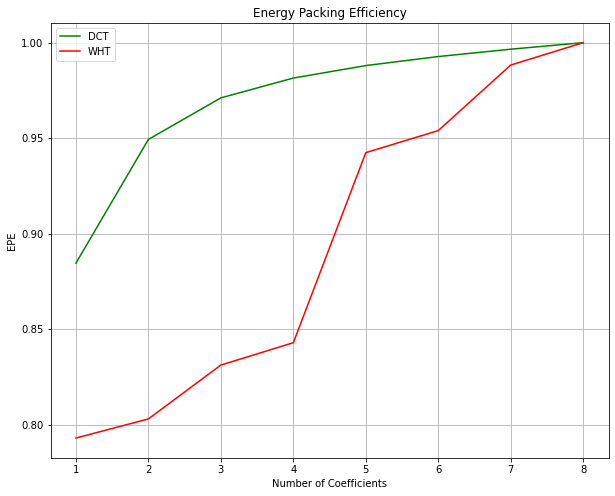

In [18]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(n)+1, epe_dct, 'g')
plt.plot(np.arange(n)+1, epe_wht, 'r')
plt.xlabel("Number of Coefficients")
plt.ylabel("EPE")
plt.title("Energy Packing Efficiency")
plt.legend(["DCT", "WHT"])
plt.grid(True)
plt.show()

## Decorrelation Efficiency

In [19]:
print(f"Decorrelation Efficiency of R for DCT : {dce_dct}")
print(f"Decorrelation Efficiency of R for WHT : {dce_wht}")

Decorrelation Efficiency of R for DCT : 0.9731490340720335
Decorrelation Efficiency of R for WHT : 0.9485667904674057


## Eigenvectors of R and DCT Basis Vectors

In [20]:
print(np.round(dct, decimals=2))

[[ 1.269e+01  0.000e+00 -4.100e-01  0.000e+00 -9.000e-02 -0.000e+00
  -3.000e-02  0.000e+00]
 [ 0.000e+00  9.300e-01  0.000e+00 -3.000e-02  0.000e+00 -1.000e-02
   0.000e+00 -0.000e+00]
 [-4.100e-01  0.000e+00  3.100e-01  0.000e+00 -0.000e+00  0.000e+00
  -0.000e+00 -0.000e+00]
 [ 0.000e+00 -3.000e-02  0.000e+00  1.500e-01  0.000e+00 -0.000e+00
   0.000e+00 -0.000e+00]
 [-9.000e-02 -0.000e+00 -0.000e+00  0.000e+00  9.000e-02  0.000e+00
  -0.000e+00 -0.000e+00]
 [-0.000e+00 -1.000e-02  0.000e+00 -0.000e+00  0.000e+00  7.000e-02
   0.000e+00 -0.000e+00]
 [-3.000e-02  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00
   6.000e-02 -0.000e+00]
 [ 0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
   0.000e+00  5.000e-02]]


## Scaled Inverse of R

In [21]:
print(np.round(bsr_inv, 3))

[[ 0.547 -0.498 -0.     0.    -0.    -0.     0.    -0.   ]
 [-0.498  1.    -0.498 -0.     0.     0.    -0.     0.   ]
 [-0.    -0.498  1.    -0.498  0.    -0.     0.    -0.   ]
 [-0.    -0.    -0.498  1.    -0.498  0.    -0.     0.   ]
 [-0.     0.     0.    -0.498  1.    -0.498  0.     0.   ]
 [-0.     0.    -0.     0.    -0.498  1.    -0.498 -0.   ]
 [ 0.    -0.     0.     0.    -0.    -0.498  1.    -0.498]
 [-0.     0.    -0.     0.     0.    -0.    -0.498  0.547]]


## Tridiagonal Matrix

In [22]:
print(np.round(Q, 3))

[[ 0.502 -0.498  0.     0.     0.     0.     0.     0.   ]
 [-0.498  1.    -0.498  0.     0.     0.     0.     0.   ]
 [ 0.    -0.498  1.    -0.498  0.     0.     0.     0.   ]
 [ 0.     0.    -0.498  1.    -0.498  0.     0.     0.   ]
 [ 0.     0.     0.    -0.498  1.    -0.498  0.     0.   ]
 [ 0.     0.     0.     0.    -0.498  1.    -0.498  0.   ]
 [ 0.     0.     0.     0.     0.    -0.498  1.    -0.498]
 [ 0.     0.     0.     0.     0.     0.    -0.498  0.502]]


## Diagonalizing Ability of DCT


We know that DCT diagonalizes matrices with a tridiagonal structure, $Q_{\alpha}$. We also try to diagonalize $\beta^{2}R^{-1}$ as defined in the previous section using DCT.

For $\beta^{2}R^{-1}$, the matrix is almost diagonal, i.e., most of the off-diagonal elements have small values.

In [23]:
print(np.round(bsr_inv_dct, 3))

[[ 0.031 -0.     0.021 -0.     0.016 -0.     0.009  0.   ]
 [-0.     0.102 -0.     0.018  0.     0.012  0.     0.004]
 [ 0.021 -0.     0.315 -0.     0.015  0.     0.008  0.   ]
 [-0.     0.018  0.     0.634  0.     0.01   0.     0.004]
 [ 0.016  0.     0.015  0.     1.011  0.     0.006  0.   ]
 [ 0.     0.012  0.     0.01   0.     1.388  0.     0.002]
 [ 0.009  0.     0.008  0.     0.006  0.     1.707 -0.   ]
 [ 0.     0.004  0.     0.004  0.     0.002 -0.     1.921]]


In [24]:
print(np.round(Q_dct, 3))

[[ 0.009  0.    -0.     0.     0.    -0.    -0.     0.   ]
 [ 0.     0.08  -0.     0.    -0.    -0.     0.    -0.   ]
 [ 0.    -0.     0.296  0.    -0.     0.    -0.     0.   ]
 [-0.     0.     0.     0.619  0.    -0.     0.    -0.   ]
 [-0.    -0.    -0.     0.     1.     0.    -0.    -0.   ]
 [ 0.    -0.     0.    -0.     0.     1.381  0.     0.   ]
 [ 0.     0.    -0.     0.    -0.     0.     1.704 -0.   ]
 [ 0.    -0.     0.    -0.    -0.     0.    -0.     1.92 ]]


## SVD Reconstruction

In [25]:
print(np.round(mat, 3))

[[207 244 107 173  70 111 180 244]
 [230 246 233 193  11  97 192  86]
 [ 32  40 202 189  24 195  70 149]
 [232 247 244 100 209 202 173  57]
 [161 244 167 167 177  47 167 191]
 [ 24 123   9  43  80 124  41  65]
 [ 71 204 216 180 242 113  30 129]
 [139  36 238   8   8 164 127 178]]


In [26]:
print(np.round(re_mat, 3))

[[207. 244. 107. 173.  70. 111. 180. 244.]
 [230. 246. 233. 193.  11.  97. 192.  86.]
 [ 32.  40. 202. 189.  24. 195.  70. 149.]
 [232. 247. 244. 100. 209. 202. 173.  57.]
 [161. 244. 167. 167. 177.  47. 167. 191.]
 [ 24. 123.   9.  43.  80. 124.  41.  65.]
 [ 71. 204. 216. 180. 242. 113.  30. 129.]
 [139.  36. 238.   8.   8. 164. 127. 178.]]


## Reconstruction Errors

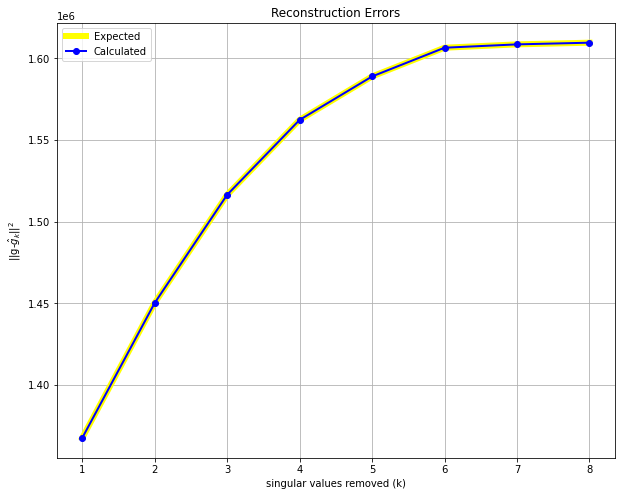

In [27]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(n)+1, re_error_expected, color = 'yellow',linewidth = 6)
plt.plot(np.arange(n)+1, re_error_calculated, '-o', color = 'blue', linewidth = 2)
plt.xlabel("singular values removed (k)")
plt.ylabel(r'||g-$\hat{g}_{k}||^{2}$')
plt.legend(["Expected", "Calculated"])
plt.title("Reconstruction Errors")
plt.grid(True)
plt.show()

# OBSERVATIONS:

We can observe that:
    
* DCT is better than WHT at both energy packing and decorrelation 

* DCT exactly diagonalises $Q_{\alpha}$, a triadigonal matrix with parameter $\alpha$ and almost but not completely diagonalises $\beta^2 R^{-1}$ 

* Eigen values of R are close to the DCT basis vectors but not exactly same

* Reconstructed and computed SVD for the image gives same result
